# 0. 기본세팅 & 크롤링 데이터 로드

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install JPype1-1.2.0-cp38-cp38-win_amd64.whl
!pip install konlpy==0.5.2
!pip install tweepy==3.10.0
!pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: JPype1-1.2.0-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 453 kB 57.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 232 kB 7.2 MB/s 
     |████████████████████████████████| 51 kB 3.5 MB/s 
     |████████████████████████████████| 4.2 MB 17.7 MB/s 
     |████████████████████████████████| 1.2 MB 41.7 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 17.6 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
  Created wheel for keybert: filename=keybert-0.5.1-py3-none-any.whl size=21332 sha256=b442174057d51182d46d50873f02f4098b4b34d909a68482f59c0566e54e644e
  Stored in directory: /root/.cache/pip/wheels/8e/95/c5/f5ceed2a9f9e80bc1a706a10a6fb03d726df7a3dd11800a58b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-no

In [10]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT


In [11]:
data = pd.read_excel('/content/drive/MyDrive/와이빅타/DA_주니어플젝/데이터_2022.05.29.xlsx')
data_raw = data.copy()
data.head()

,Title,url,thumbnail
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...


# 1. 전처리

In [12]:
komoran = Komoran()
hannanum = Hannanum()

In [13]:
# 불용어 파일 열기
with open('/content/drive/MyDrive/와이빅타/DA_주니어플젝/korean_stopwords.txt', 'r', encoding='utf-8') as f:
    list_file = f.readlines() 
stopwords = list_file[0].split(",")

# 정규화, 특수기호 제거
def preprocess(text):
    text=text.strip()  
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(preprocess(text))

In [19]:
data['noun'] = data['title'].apply(lambda x: finalpreprocess(x))
data.head()

,title,url,thumbnail,noun
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학 방역 중대 전문가 위원회 데이터 플랫폼 구성
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 가명 정보 결합 데이터 사이언스 강화
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...,넥슨 가명 정보 결합 데이터 사이언스 강화
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스 데이터 서비스 진출 글로벌 브랜드 KT SAT


# 2. 행 추출 : 핵심키워드만 있는 행만

In [20]:
user_keyword = ['데이터', '머신러닝', '디지털', 'AI', '스마트', 	'DB', 'KAIST', '딥러닝', '기계학습', 'IT', '플랫폼', '블록체인', 	'핀테크', 'AWS', '구글', 'Google']

In [21]:
def extract_row(train):  #train은 dataframe

		# join함수를 이용하여 이어주고 contains 함수에 넣기
		user_keywords = '|'.join(user_keyword)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['title', 'url', 'thumbnail']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(preprocess(text))

In [22]:
data_extract = extract_row(data)
data_extract['noun'] = data_extract['title'].apply(lambda x: finalpreprocess_han(x))
data_extract

,title,url,thumbnail,noun
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스데이터 서비스 진출 글로벌 브랜드
...,...,...,...,...
2585,"수자원공사, 제1차 디지털 혁신 릴레이포럼 개최",http://www.ikld.kr/news/articleView.html?idxno...,,수자원공사 디지털 혁신 릴레이포럼 개최
2590,한양대 임창환 교수 AI로 가상의 뇌파신호 생성기술 개발,http://www.veritas-a.com/news/articleView.html...,https://search.pstatic.net/common/?src=https%3...,한양대 임창환 교수 가상 뇌파신호 생성기술 개발
2595,"신한베트남은행, 디지털 사업 전담 추진 조직 'Future Bank Group' 출범",https://www.onews.tv/news/articleView.html?idx...,https://search.pstatic.net/common/?src=https%3...,신한베트남은행 디지털 사업 전담 추진 조직 출범
2599,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,https://www.fetv.co.kr/news/article.html?no=11...,https://search.pstatic.net/common/?src=https%3...,한화 교보생명 오너 디지털 대결 누구


In [ ]:
# data_extract.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_han_preprocess.csv', index=False)

# 2. 클러스터링 #1 (중복기사제거)

In [23]:
text = data_extract['noun']

In [24]:
#1 tf-idf 임베딩(+Normalize)
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

vector_1st = tfidf_vectorizer(text, min_df=1)

In [25]:
#2 DBSCAN Clustering

model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_extract['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract

군집개수 : 502


,title,url,thumbnail,noun,cluster1st
0,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성,0
1,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화,1
2,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터,2
3,"넥슨, 라프텔과 가명정보 결합…""데이터 사이언스 강화""",https://www.news1.kr/articles/?4683961,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화,1
4,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스데이터 서비스 진출 글로벌 브랜드,3
...,...,...,...,...,...
2585,"수자원공사, 제1차 디지털 혁신 릴레이포럼 개최",http://www.ikld.kr/news/articleView.html?idxno...,,수자원공사 디지털 혁신 릴레이포럼 개최,364
2590,한양대 임창환 교수 AI로 가상의 뇌파신호 생성기술 개발,http://www.veritas-a.com/news/articleView.html...,https://search.pstatic.net/common/?src=https%3...,한양대 임창환 교수 가상 뇌파신호 생성기술 개발,398
2595,"신한베트남은행, 디지털 사업 전담 추진 조직 'Future Bank Group' 출범",https://www.onews.tv/news/articleView.html?idx...,https://search.pstatic.net/common/?src=https%3...,신한베트남은행 디지털 사업 전담 추진 조직 출범,206
2599,한화·교보생명 오너 3세 ‘디지털’ 대결…누가 웃나,https://www.fetv.co.kr/news/article.html?no=11...,https://search.pstatic.net/common/?src=https%3...,한화 교보생명 오너 디지털 대결 누구,501


In [28]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    counts = []
    titles = []
    urls = []
    thumbnails = []
    nouns = []
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            titles.append(temp_df.reset_index()['title'][0])
            urls.append(temp_df.reset_index()['url'][0])
            thumbnails.append(temp_df.reset_index()['thumbnail'][0])
            nouns.append(temp_df.reset_index()['noun'][0]) 

            for title in temp_df['title']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'title': titles, 'url':urls, 'thumbnail':thumbnails, 'noun': nouns})
    return cluster_result


In [29]:
cluster1_result = print_cluster_result( train=data_extract, 
                                       result=result_1st, col_cluster="cluster1st")

cluster num : 0
'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성
‘과학방역’ 나선 중대본, 전문가위원회·빅데이터 플랫폼 구성

cluster num : 1
넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화
넥슨, 라프텔과 가명정보 결합…"데이터 사이언스 강화"
넥슨, 라프텔과 가명정보 결합으로 데이터 사이언스 강화
넥슨, 라프텔과 가명정보 결합으로 데이터 사이언스 강화
넥슨, 라프텔과 가명정보 결합으로 데이터 사이언스 강화
넥슨 "라프텔과 가명정보 결합으로 데이터 사이언스 강화"

cluster num : 2
인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다

cluster num : 3
KT SAT "스페이스데이터 서비스 진출…글로벌 브랜드 키운다"

cluster num : 4
농협은행, 마이데이터 친구추천 이벤트 진행
NH농협은행, NH마이데이터 친구추천 이벤트 진행

cluster num : 5
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정 [하동소식]
하동군, 공공데이터 기업매칭 공모 선정 [하동소식]
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군, 공공데이터 기업매칭 공모 선정
하동군 공공데이터 기업매칭 공모 선정

cluster num : 6
행안부, 공기관 포함 467개 기관 데이터기반행정 점검

cluster num : 7
교통사망사고 빅데이터로 도민생명 살린다
교통사망사고 빅데이터로 도민생명 살린다

cluster num : 8
“랜섬웨어 피해 기업 3곳 중 1곳, 대가 지불해도 데이터 복구 실패”
“랜섬웨어 피해 기업 3곳 중 1곳, 대가 지불해도 데이터 복구 실패”
랜섬웨어 피해 기업 76% 금전적 대가 지불... 3분의 1은 데이터 복구 못해

cluster num :

In [30]:
cluster1_result.head()

,cluster_num,count,title,url,thumbnail,noun
0,0,2,'과학방역' 내세운 중대본…전문가위원회·빅데이터 플랫폼 구성,https://www.yna.co.kr/view/AKR2022051803830053...,https://search.pstatic.net/common/?src=https%3...,과학방역 중대본 전문가위원회 빅데이터 플랫폼 구성
1,1,6,"넥슨, 라프텔과 '가명정보 결합'…데이터 사이언스 강화",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...,넥슨 라프텔 가명정보 결합 데이터 사이언스 강화
2,2,1,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터
3,3,1,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스데이터 서비스 진출 글로벌 브랜드
4,4,2,"농협은행, 마이데이터 친구추천 이벤트 진행",http://www.edaily.co.kr/news/newspath.asp?news...,https://search.pstatic.net/common/?src=https%3...,농협은행 마이데이터 친구추천 이벤트 진행


# 3. 클러스터링 #2

In [31]:
text2 = cluster1_result['noun']
vector_2nd = tfidf_vectorizer(text2, min_df=1)

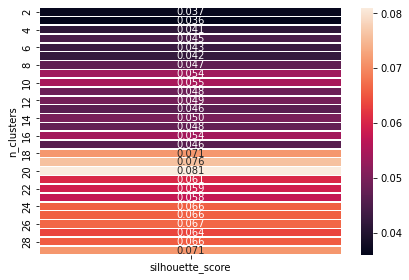

In [32]:
# Silhouette Score - 최적 k
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,30)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector_2nd) # 가장 높은 실루엣 계수와 매핑되는 k

In [33]:
# kmeans 군집 결과 확인
from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=20).fit_predict(vector_2nd)
cluster1_result['cluster2nd'] = result_2nd

cluster2_result = print_cluster_result( train=cluster1_result, 
                                       result=result_2nd, col_cluster="cluster2nd")

cluster num : 0
공공데이터 전면 개방 `가속도'
보령시, 공공데이터 전면 개방 가속도
안산시, 다문화마을특구에 상가 데이터뱅크 구축... 공공데이터 개방
유성구,구민생활 밀접 공공데이터 개방 추진
보령시, '한방에 몰아보는 스마트한 전통시장 DB 구축·개방' 사업 선정

cluster num : 1
KT SAT "스페이스데이터 서비스 진출…글로벌 브랜드 키운다"
행안부, 공기관 포함 467개 기관 데이터기반행정 점검
인천관광공사 공공데이터 기업매칭사업 국비 10억
한국축산데이터, 축산분야 亞최초 영국 GEP 선정…"유럽 진출 본격화"
[빅데이터MSI]18일 오전 주식시장 심리 4단계 '보통'
환경자원 데이터 플랫폼 '빼기', 25억 규모 후속투자 유치 성공
[데이터뉴스]'벤처펀드 1조' VC 7곳
한국빅데이터학회, '빅데이터AI포럼' 창립
[현장] 아시아 최대 KTSAT 금산위성센터, 우주데이터 사업 기지 된다
한세예스24홀딩스, 박현영 데이터분석가 초청해 강연회 열어
데이터시티위마켓, 메타버스허브 웹3.0 구축
한국데이터법정책학회, 20일 "데이터법과 정책의 이슈와 과제" 정기학술대회
[데이터경제] 중국, 어느새 비트코인 채굴 2위로 부상...중국정부, 금지 조치에도 급증
(친환경이 미래다⑩)'전기 먹는 하마' 데이터센터…"친환경 전력 사용 고려해야"
[시론] 스마트팜은 데이터농업이다
“인천경제자유구역 블록체인 특구화하겠다” 유정복
AI는 미래 경찰관! '대한민국 바꿀 10가지 기술'은 어떤 것?
HDC현대산업개발, '스마트 주차장 솔루션' 개발
LG CNS, 5조4천억 부산스마트시티 따냈다
인천관광공사, 인천 최초'관광지 데이터 구축 공공데이터' 공모 선정
과학적 국정운영 토대 마련, 데이터기반행정 실태 점검한다
한국축산데이터, 축산 분야 아시아 최초 영국 GEP 선정
[데이터뉴스]'벤처펀드 1조' VC 7곳
한국빅데이터학회, '빅데이터AI포럼' 창립
인천관광공사,행안부 '관광지 데이터 구축 공공데이터'공모 선정
한국축산데이터, 유럽 진출 속도

# 4. keyword 추출

In [34]:
key_model = KeyBERT('distilbert-base-nli-mean-tokens') 

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [43]:
def keyword(data, col_cluster):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    result = []
    for i in range(len(data)):
        key_text = cluster1_result[cluster1_result[col_cluster]==i]['noun']
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,2), top_n=1) 
        result.append(keyword[0][0])
    return result

def merge_keyword(data, col_cluster): #새 열로 추가.
    data_temp = data.copy()
    data_temp['keyword'] = keyword(data, col_cluster)
    return data_temp

In [64]:
keyword_result = merge_keyword(cluster2_result, col_cluster='cluster2nd')
keyword_result 

,cluster_num,count,title,url,thumbnail,noun,keyword
0,0,5,공공데이터 전면 개방 `가속도',http://www.cctimes.kr/news/articleView.html?id...,,공공데이터 전면 개방 가속도,다문화마을특구 상가
1,1,284,"KT SAT ""스페이스데이터 서비스 진출…글로벌 브랜드 키운다""",https://www.hankyung.com/it/article/202205184568i,https://search.pstatic.net/common/?src=https%3...,스페이스데이터 서비스 진출 글로벌 브랜드,신한베트남은행 퓨처뱅크그룹
2,2,14,"신한베트남은행, 디지털 사업 전담 추진 조직",http://www.edaily.co.kr/news/newspath.asp?news...,https://search.pstatic.net/common/?src=https%3...,신한베트남은행 디지털 사업 전담 추진 조직,신한베트남은행 디지털사업
3,3,8,"신한베트남은행, 디지털 사업 전담 '퓨처 뱅크 그룹' 출범",https://www.hankyung.com/economy/article/20220...,https://search.pstatic.net/common/?src=https%3...,신한베트남은행 디지털 사업 전담 퓨처 뱅크 그룹 출범,신한베트남은행 디지털
4,4,7,"뷰노, 국내 의료 AI 최초 선진입 의료기술 확정",http://www.etnews.com/20220518000235,https://search.pstatic.net/common/?src=https%3...,뷰노 국내 의료 최초 선진입 의료기술 확정,선진입 의료기술
5,5,3,"LG전자, ‘IEEE ICC’에서 스마트 모빌리티·6G 분야 혁신 기술 알린다",http://www.boannews.com/media/view.asp?idx=106...,https://search.pstatic.net/common/?src=https%3...,전자 스마트 모빌리티 분야 혁신 기술,전자 스마트
6,6,4,"NH농협생명, AI 활용한 머신러닝으로 보험사기분석시스템 고도화",http://daily.hankooki.com/news/articleView.htm...,https://search.pstatic.net/common/?src=https%3...,농협생명 활용 머신러닝 보험사기분석시스템 고도화,농협생명 보험사기분석시스템
7,7,5,"구글 I/O, '구글클라우드' 혁신…아마존보다 2배 빠르다",http://www.inews24.com/view/1481867,https://search.pstatic.net/common/?src=https%3...,구글 구글클라우드 혁신 아마존,한국 디지털서비스
8,8,5,"아크릴, AI 기반 '코로나 자가격리 건강관리 시스템' 개발",https://www.ebn.co.kr/news/view/1530962/?sc=Naver,https://search.pstatic.net/common/?src=https%3...,아크릴 기반 자가격리 건강관리 시스템 개발,아크릴 삼성서울병원
9,9,29,"인공위성 '세종 1호' 쏘는 한글과컴퓨터, 이미지 데이터 노린다",http://www.bloter.net/newsView/blt202205180027,https://search.pstatic.net/common/?src=https%3...,인공위성 세종 한글과컴퓨터 이미지 데이터,세종 한글과컴퓨터


In [69]:
keyword_df = keyword_result[['cluster_num', 'count', 'keyword']]
keyword_df.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
keyword_df.drop(index=[0], inplace=True)
keyword_df = keyword_df[keyword_df['count']>5]
keyword_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,cluster_num,count,keyword
1,16,47,부산스마트시티사업 우선협상대상자
2,12,34,분석결과 과기원통증연구단
3,9,29,세종 한글과컴퓨터
4,2,14,신한베트남은행 디지털사업
5,15,10,인천관광공사 공공데이터
6,10,9,삼성카드 마이데이터
7,3,8,신한베트남은행 디지털
8,14,7,농협은행 마이데이터
9,4,7,선진입 의료기술
10,18,7,신한베트남은행 디지털사업


In [ ]:
# keyword_df.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/keyword_result.csv', index=False)

# 5. 최종 데이터

In [55]:
cluster1_result.columns

Index(['cluster_num', 'count', 'title', 'url', 'thumbnail', 'noun',
       'cluster2nd'],
      dtype='object')

In [56]:
keyword_df.columns

Index(['cluster_num', 'count', 'keyword'], dtype='object')

In [71]:
temp_df = cluster1_result[['title', 'url', 'thumbnail', 'cluster2nd']]
final = keyword_df.merge(temp_df, left_on='cluster_num', right_on='cluster2nd').drop(columns=['cluster2nd', 'count'])
final 

,cluster_num,keyword,title,url,thumbnail
0,16,부산스마트시티사업 우선협상대상자,"에너지밸런스, '2022 데이터스타즈' 대상기업 선정",http://www.etnews.com/20220518000121,https://search.pstatic.net/common/?src=https%3...
1,16,부산스마트시티사업 우선협상대상자,"과기정통부, 데이터사이언스 융합인재양성사업에 고려대·KAIST 선정",https://www.itbiznews.com/news/articleView.htm...,https://search.pstatic.net/common/?src=https%3...
2,16,부산스마트시티사업 우선협상대상자,"LG CNS 컨소시엄, 5.4조원 규모 부산 스마트시티 시범사업 수주",https://zdnet.co.kr/view/?no=20220518151308,https://search.pstatic.net/common/?src=https%3...
3,16,부산스마트시티사업 우선협상대상자,"현대건설, 부산 에코델타 스마트시티 우선협상대상자 선정",http://www.newsis.com/view/?id=NISX20220518_00...,https://search.pstatic.net/common/?src=https%3...
4,16,부산스마트시티사업 우선협상대상자,"LG CNS, 국내최대 스마트시티사업 '부산 에코델타' 우선협상대상",https://www.yna.co.kr/view/AKR2022051811070001...,https://search.pstatic.net/common/?src=https%3...
...,...,...,...,...,...
187,13,다문화마을특구 상권db,"안산시, 다문화마을특구 상권DB 구축한다",https://www.ajunews.com/view/20220518090558197,https://search.pstatic.net/common/?src=https%3...
188,13,다문화마을특구 상권db,"안산시, 다문화마을특구 상권DB 구축…행안부 공모 선정",https://www.yna.co.kr/view/AKR2022051806130006...,https://search.pstatic.net/common/?src=https%3...
189,13,다문화마을특구 상권db,안산시 다문화마을특구 상권DB 구축...국비 2억5000만원 투입,http://www.newspim.com/news/view/20220518000095,https://search.pstatic.net/common/?src=https%3...
190,13,다문화마을특구 상권db,"안산시, 다문화마을특구 상권DB 구축해 시민 편의성 향상",http://www.newsfreezone.co.kr/news/articleView...,https://search.pstatic.net/common/?src=https%3...


In [ ]:
# temp_df.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/reports.csv', index=False')
# final.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final.csv', index=False')